In [1]:
import glob
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import moly
from tqdm import tqdm
import scienceplots


from HEML.utils.data import mat_pull
from HEML.utils.fields import split_and_filter, pca
from HEML.utils.visualization import (
    shift_and_rotate, 
    get_nodes_and_edges_from_pdb,
    mat_to_cones
    )

from HEML.utils.fields import split_and_filter, pca
from HEML.utils.data import *
from HEML.utils.attrib import *
from HEML.utils.model import *
from HEML.utils.dictionaries import *

In [2]:
def get_files(folder): 
    files =  glob(folder + "**/*.dat", recursive=True)
    return files


folder_wt = "/home/santiagovargas/dev/HEML/data/shobhit_md_full/WT/"
folder_glv = "/home/santiagovargas/dev/HEML/data/shobhit_md_full/GLV/"
folder_gla = "/home/santiagovargas/dev/HEML/data/shobhit_md_full/GLA/"

files_wt = get_files(folder_wt)
files_glv = get_files(folder_glv)
files_gla = get_files(folder_gla)

In [3]:
mat_wt, mat_glv, mat_gla = [], [], []

for file in tqdm(files_wt):
    mat_wt.append(mat_pull(file))
for file in tqdm(files_glv):
    mat_glv.append(mat_pull(file))
for file in tqdm(files_gla):
    mat_gla.append(mat_pull(file))
    

100%|██████████| 4972/4972 [01:09<00:00, 71.23it/s]


In [4]:
cones = []
cutoff=0
components = 25
vector_scale = 3
bounds={'x': [-4.0, 4.0], 'y': [-4.0, 4.0], 'z': [-4.0, 4.0]}
step_size = {"x": 0.4, "y": 0.4, "z": 0.4}

full_mat = np.array(mat_wt + mat_glv + mat_gla)

#arr_min, arr_max,  = np.min(x), np.max(x)
#x_sign = np.sign(full_mat)
# getting absolute value of every element
#x_abs = np.abs(full_mat)
# applying log1p
#x_log1p = np.log1p(x_abs)
# getting sign back
#full_mat = np.multiply(x_log1p, x_sign)


x_wt = full_mat[:len(mat_wt)]
x_glv = full_mat[len(mat_wt):len(mat_wt)+len(mat_glv)]
x_gla = full_mat[len(mat_wt)+len(mat_glv):]

x_pca, pca_obj = pca(
    full_mat, 
    whitening=True,
    verbose = True, 
    pca_comps = components, 
    write = False) 
shape_mat = full_mat.shape

for ind,pca_comp in enumerate(pca_obj.components_):
    comp_vect_field = pca_comp.reshape(shape_mat[1], shape_mat[2], shape_mat[3], shape_mat[4])
    bohr_to_ang = 1.88973
    x, y, z = np.meshgrid(
                np.arange(bounds['x'][0] * bohr_to_ang, (bounds['x'][1]+step_size['x']) * bohr_to_ang, step_size['x']* bohr_to_ang),
                np.arange(bounds['y'][0] * bohr_to_ang, (bounds['y'][1]+step_size['y']) * bohr_to_ang, step_size['y']* bohr_to_ang),
                np.arange(bounds['z'][0] * bohr_to_ang, (bounds['z'][1]+step_size['z']) * bohr_to_ang, step_size['z']* bohr_to_ang)
            )

    u_1, v_1, w_1 = split_and_filter(
        comp_vect_field, 
        cutoff=cutoff, 
        std_mean=False, 
        min_max=False,
        log1=False
        )
    
    cones.append(go.Cone(
        x=x.flatten(), 
        y=y.flatten(), 
        z=z.flatten(), 
        u=u_1,
        v=v_1, 
        w=w_1,
        sizeref=vector_scale,
        opacity=0.4, 
        showscale=False,
        colorscale='Greens',))
    


cumulative explained vars ratio: 
[0.06016053608435677, 0.09582904522409354, 0.12508717031828062, 0.1468870881699267, 0.1669628082453879, 0.184946533932583, 0.20120911020893556, 0.21602064023089945, 0.2298040797047544, 0.24252844335738324, 0.25441861778386343, 0.26588146860043393, 0.276650272194698, 0.2863549163732537, 0.2951247286716107, 0.3034039701033603, 0.3116795163523298, 0.31966003782506525, 0.3272949121353539, 0.3345473786682817, 0.3413861051778773, 0.3479861397199556, 0.35452631790566386, 0.3609822718826565, 0.3673705890526263]


In [5]:
#%matplotlib inline
from scipy.stats import gaussian_kde

plt.style.use('seaborn-v0_8-paper')

def create_hist_plot(data, kernel=0.7):
    if type(data) is list:
        xs_list, density_list = [], []
        for _, d in enumerate(data):
            xs = np.linspace(-5, 5, 200)
            density = gaussian_kde(d)
            density.covariance_factor = lambda : kernel

            density._compute_covariance()
            xs, density(xs)
            
            xs_list.append(xs)
            density_list.append(density(xs))
        return xs_list, density_list

    else:
        xs = np.linspace(-5, 5, 200)
        density = gaussian_kde(data)
        density.covariance_factor = lambda : kernel
        density._compute_covariance()
        return xs, density(xs)
    

def plot_hist_along_component(x_list, pca_obj, components): 
    
    if type(components) is list:
        fig, axs = plt.subplots(len(components), 1)
        names = ["PC {}".format(str(temp)) for temp in components]

        for ind, comp in enumerate(components):
            list_data = []
            for _, x in enumerate(x_list):
                x_pca, _ = pca(x, pca=pca_obj, verbose = False, write = False) 
                x_pca = x_pca[:,comp]
                list_data.append(x_pca)
            
            xs_list, density_list = create_hist_plot(list_data, kernel=0.25)  
            
            for i in range(len(xs_list)):
                axs[ind].plot(
                    xs_list[i], 
                    density_list[i], 
                    color = ["#1f77b4", "#ff7f0e", "#2ca02c"][i],
                    label = ["WT", "GLV", "GLA"][i]
                )
                
            axs[ind].set_title(names[ind], fontsize=16)
            axs[ind].set_ylabel("Density", fontsize=14)
            axs[ind].legend()
            for axs[ind] in axs:
                axs[ind].tick_params(labelsize=14) 
        
        fig.set_size_inches(6, 50)
        #fig.show()
    
    else: 
        list_data = []
        for _, x in enumerate(x_list):
            x_pca, _ = pca(x, pca=pca_obj, verbose = False, write = False) 
            x_pca = x_pca[:,components]
            list_data.append(x_pca)

        xs_list, density_list = create_hist_plot(list_data)        
        
        fig, axs = plt.subplots(1,1)

        for i in range(len(xs_list)):
            axs.plot(
                xs_list[i], 
                density_list[i], 
                color = ["#1f77b4", "#ff7f0e", "#2ca02c"][i],
                label = ["WT", "GLV", "GLA"][i])
        
        axs = fig.get_axes()
        # update y axis 
        axs[0].set_ylabel("Density", fontsize=14)
        axs[0].legend()
        # set size 
        fig.set_size_inches(5, 3)
        # set title
        fig.suptitle("PCA Component " + str(components))
        # set font size
        for ax in axs:
            ax.tick_params(labelsize=14)        
        #fig.show()
#plot_hist_along_component([x_wt, x_glv, x_gla], pca_obj, 5)



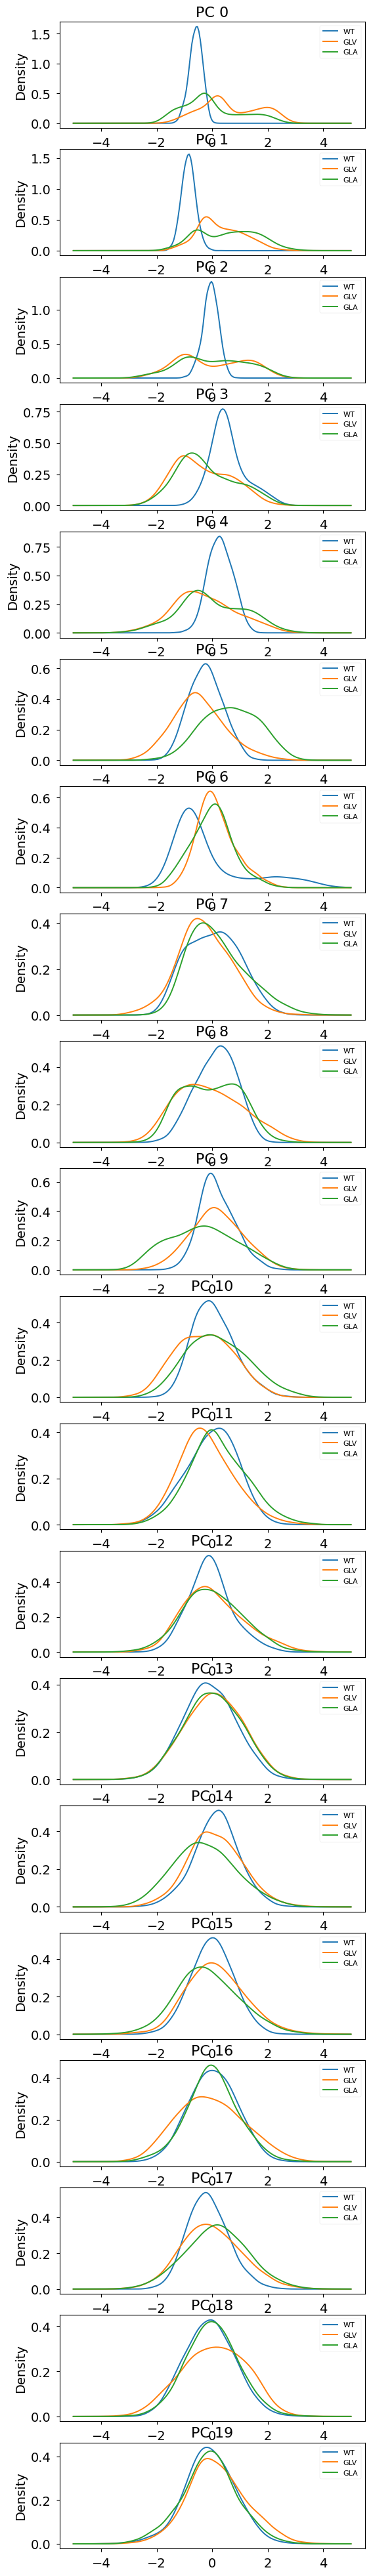

In [6]:
plot_hist_along_component([x_wt, x_glv, x_gla], pca_obj, [i for i in range(20)])


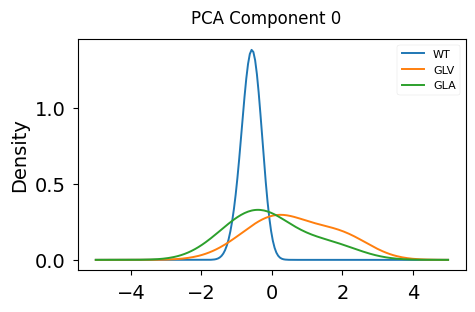

In [7]:
plot_hist_along_component([x_wt, x_glv, x_gla], pca_obj,0)


In [9]:
from HEML.utils.fields import save_numpy_as_dat
meta_dict = mat_pull("/home/santiagovargas/dev/HEML/data/shobhit_md_full/WT/fields_wt_run1/cpet/average_field.dat", meta_data=True)


save_numpy_as_dat(
    dict_meta_data = meta_dict, 
    average_field=pca_obj.components_[0].reshape(shape_mat[1], shape_mat[2], shape_mat[3], shape_mat[4]), 
    save_root = "../../data/shobhit_md_full/PC_mats/PC0/field"
)


{'first_line': '#Sample Density: 10 10 10; Volume: Box: 4.000000 4.000000 4.000000\n',
 'steps_x': 21,
 'steps_y': 21,
 'steps_z': 21,
 'step_size_x': 0.4,
 'step_size_y': 0.4,
 'step_size_z': 0.4,
 'bounds_x': [-4.0, 4.4],
 'bounds_y': [-4.0, 4.4],
 'bounds_z': [-4.0, 4.4]}

In [13]:
def get_molecule_dict(file = "../../data/pdbs_processed/1a4e.pdb"):
    
    atom_list, bond_list, xyz_list = get_nodes_and_edges_from_pdb(
        file, 
        distance_filter=8.5,
        filter_connectivity=True,
        heme_filter=True)
    
    NA_pos = [129.775,  39.761,  38.051]
    NB_pos = [130.581,  41.865,  36.409]
    NC_pos = [131.320,  43.348,  38.639]
    ND_pos = [130.469,  41.267,  40.273]
    Fe_pos = [130.581,  41.541,  38.350]
    center = np.mean([NA_pos, NB_pos, NC_pos, ND_pos], axis = 0)
    x_axis = np.array(NA_pos) - np.array(Fe_pos)
    x_axis = x_axis / np.linalg.norm(x_axis)
    y_axis = np.array(NB_pos) - np.array(Fe_pos)
    y_axis = y_axis / np.linalg.norm(y_axis)
    z_axis = np.cross(y_axis, x_axis)
    z_axis = z_axis / np.linalg.norm(z_axis)

    xyz_list = shift_and_rotate(
        xyz_list, 
        center = center, 
        x_axis = x_axis,
        y_axis = y_axis,
        z_axis = z_axis
    )
    diag_dict = {"Fe": [], "N": []}
    string_element = "\n{}\n\n".format(len(atom_list))
    for i, atom in enumerate(atom_list):
        # check if nitrogen
        if atom == 7:
            diag_dict["N"].append(xyz_list[i])
        if atom == 26: 
            
            diag_dict["Fe"].append(xyz_list[i])
        string_element +="{} {} {} {}\n".format(int_atom_dict[atom], xyz_list[i][0], xyz_list[i][1], xyz_list[i][2])
    dict_input = {"symbols": atom_list, "geometry": xyz_list, "connectivity": bond_list}
    return string_element, dict_input


def plot_field(
    field, 
    name,
    molecule_file="../../data/pdbs_processed/1a4e.pdb",
    ):

    string_element, dict_input = get_molecule_dict(molecule_file)

    component = mat_to_cones(
        field, 
        (1, 21, 21, 21, 3),
        bohr_to_ang_conv=True, 
        vector_scale=1,
        std_mean=False,  
        log1=False, 
        unlog1=False,
        min_max=False,
        cutoff=99.8)

    fig = moly.Figure()
    molecule = moly.Molecule.from_data(string_element, dtype="string")
    fig.add_molecule("heme", molecule)
    fig.add_trace(component)
    # add cube to show the center of the molecule from -3 to 3
    fig.fig.update_layout(yaxis_range=[-4,4], xaxis_range=[-4,4])

    config = {
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'custom_image',
        'height': 2000,
        'width': 2000,
        'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
    }
    }
    fig.fig.update_scenes(
        xaxis_visible=False, 
        yaxis_visible=False,
        zaxis_visible=False)
    fig.fig.update(
        layout_showlegend=False)
    camera = dict(
        up=dict(x=0, y=0, z=0.7),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=0.25, y=0.25, z=0.3)
    )
    fig.fig.update_layout(scene_camera=camera, dragmode='orbit')
    #fig.fig.show(config=config)
    fig.fig.write_html("./{}.html".format(name), config=config)


In [14]:
for i in [0, 1, 2, 3, 7, 8, 9, 4, 5]:
    plot_field(
        pca_obj.components_[i], 
        name = "PC{}".format(i),
        molecule_file="../../data/pdbs_processed/1a4e.pdb"
        )

(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
(21, 21, 21)
